#### Script that evalueates the synthetic profiles for the 4 types of profiles present

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle
import scipy.stats
from scipy.stats import *

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

from synthetic_profiles_functions import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [2]:
X = genX([1994,2014],drop_0 = True)

dropping all zero rows


In [3]:
profileIDs = pd.read_pickle('ProfileIDs.pkl') # Read pickle file

## High Season Weekdays a.k.a. Winter Weekdays


In [4]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends

# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekdays =  df_winter_weekdays[df_winter_weekdays.ProfileID.isin(profileIDs)]
# df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

# High Season Weekends a.k.a. Winter Weekends

In [5]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekends = ['Sunday', 'Saturday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekends), 'weekend')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekend  = df_winter[df_winter['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_winter_weekend.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekend = df_winter_weekend[df_winter_weekend.ProfileID.isin(profileIDs)]

## Low Season Weekday a.k.a. Not Winter Weekday

In [6]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekdays), 'weekday')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekday  = df_summer[df_summer['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_summer_weekday.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekday = df_summer_weekday[df_summer_weekday.ProfileID.isin(profileIDs)]

## Low Season Weekend a.k.a. Not Winter Weekend

In [7]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekends), 'weekend')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekends  = df_summer[df_summer['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_summer_weekends.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekends = df_summer_weekends[df_summer_weekends.ProfileID.isin(profileIDs)]

# Load The Gauss Fit Features

## High Season Weekdays

In [8]:
season = "High_Season_Weekends" #HighSeason_weekdays, Low_season_weekdays, Low_season_weekends, High_season_weekends


if season == "Low_season_weekdays":
    cleaned_df = df_summer_weekday.copy()

elif season == "Low_season_weekends":
    cleaned_df = df_summer_weekends.copy()

elif season == "HighSeason_weekdays":
    cleaned_df = df_winter_weekdays.copy()
    
elif season == "High_Season_Weekends":
    cleaned_df = df_winter_weekend.copy()


gaus_fit_features = pd.read_csv('FitFeatures_' + season + '.csv')
gauss_profileIds = gaus_fit_features['ProfileID'].unique()
cleaned_df_profile_ids = cleaned_df['ProfileID'].unique()

profileIDs_2 = np.intersect1d(gauss_profileIds, cleaned_df_profile_ids)

cleaned_df = cleaned_df.loc[cleaned_df.ProfileID.isin(profileIDs_2),:]
gauss_fit_features = gaus_fit_features.loc[gaus_fit_features.ProfileID.isin(profileIDs_2),:]

## Extract the Amplitudes from the measured profiles

In [10]:
# Create cols
cols = ['ProfileID','A1','A2','mu1','mu2']

# Create dummy variables
mu1 = 0
A1 = 0 
mu2 = 0
A2 = 0

data=[['DROP_ROW',A1,A2,mu1,mu2]]

amplitudes_df = pd.DataFrame(data, columns=cols)

profileIDs_3 = gauss_fit_features['ProfileID'].unique()

for id in tqdm(profileIDs_3):
    for index in cleaned_df[cleaned_df['ProfileID'] == id].index:
        A1, A2, mu1, mu2, check = extractToPs(cleaned_df[cleaned_df['ProfileID'] == id].loc[index])
        if check == False:
            continue
        
        data=[[id,A1,A2,mu1,mu2]]
        temp_df = pd.DataFrame(data, columns=cols)
        # temp_df.set_index(['ProfileID'])
        amplitudes_df = amplitudes_df.append(temp_df)
    
amplitudes_df = amplitudes_df.set_index(['ProfileID'])
temporary = amplitudes_df.copy()
temporary.drop(['DROP_ROW'],axis = 0, inplace = True)

  0%|          | 0/9789 [00:00<?, ?it/s]

# Save all the peak values of the measured profiles

In [11]:
temporary.to_csv("High_Season_weekends_amplitudes.csv")

In [12]:
def standard_deviation(my_list):
    #calculate population standard deviation of list 
    return (sum((x-(sum(my_list) / len(my_list)))**2 for x in my_list) / len(my_list))**0.5

In [13]:
daily_consumption = pd.DataFrame()

daily_consumption['Daily_Consumption'] = cleaned_df.set_index(["ProfileID"]).sum(axis = 1)

std_deviation_df = pd.DataFrame(index = temporary.index.unique())

for id in tqdm(temporary.index.unique()):
    try:
        std_deviation_df.loc[id,'A1_std'] = standard_deviation(temporary.loc[id]['A1'])
        std_deviation_df.loc[id,'A2_std'] = standard_deviation(temporary.loc[id]['A2'])
        std_deviation_df.loc[id,'mu1_std'] = standard_deviation(temporary.loc[id]['mu1'])
        std_deviation_df.loc[id,'mu2_std'] = standard_deviation(temporary.loc[id]['mu2'])
        std_deviation_df.loc[id,'DC_std'] = standard_deviation(daily_consumption.loc[id]['Daily_Consumption'])
    except TypeError:
        print('TypeError')
        continue

  0%|          | 0/9787 [00:00<?, ?it/s]

TypeError


In [14]:
gauss_fit_features.set_index(['ProfileID'], inplace = True)
combined_df = pd.merge(gauss_fit_features,std_deviation_df, left_index = True, right_index = True)

## Loop that extracts the distributions fitted to user profiles measured peaks

In [15]:
profiles_ids = combined_df.index.unique().values

cols = pd.MultiIndex.from_tuples([#("ProfileID",''),
                                ('A1', 'Distribution'),
                                 ("A1", "chi_square"), 
                                  ("A1", "params"), 
                                  ("A2", "Distribution"),
                                  ("A2", "chi_square"),
                                  ("A2", "params") 
                                  #, ('t1', 'Distribution'),
                                  # ("t1", "chi_square"), 
                                  # ("t1", "params"), 
                                  # ("t2", "Distribution"),
                                  # ("t2", "chi_square"),
                                  # ("t2", "params"),
                                ])
distributions_df = pd.DataFrame(index = profiles_ids,columns = cols)
results = []
for id in tqdm(profiles_ids):
  # Extract the best distribution fitted
  try:
    results1 = fit_distribution(temporary.loc[id],'A1',0.99,0.01)
    results2 = fit_distribution(temporary.loc[id],'A2',0.99,0.01)
    # results3 = fit_distribution(temporary.loc[id],'mu1',0.99,0.01)
    # results4 = fit_distribution(temporary.loc[id],'mu2',0.99,0.01)

    results = [results1.values[0],results1.values[1],results1.values[2], results2.values[0],results2.values[1],results2.values[2]]
              # ,results3.values[0],results3.values[1],results3.values[2], results4.values[0],results4.values[1],results4.values[2]]

    distributions_df.loc[id] = results
  except Exception:
    continue

  0%|          | 0/9787 [00:00<?, ?it/s]

In [16]:
distributions_df.to_csv('High_Season_Weekends_Distributions.csv')

# Loop that generates the synthetic peaks from the fitted distributions

In [17]:
level_0 = distributions_df.columns.get_level_values(0).unique()
inv_data_df = pd.DataFrame()
temp_df_inv = pd.DataFrame()
for houseID in tqdm(distributions_df.index):
    for column in level_0:

        distributions = distributions_df[column].loc[houseID]['Distribution']
        parameters = distributions_df[column].loc[houseID]['params']

        loc = combined_df.loc[houseID][column] + combined_df.loc[houseID]['H_offset']
        scale = combined_df.loc[houseID][column + '_std']  
        # loc = parameters[-2]
        # scale = parameters[-1]
        size = len(cleaned_df[cleaned_df['ProfileID'] == houseID])
        try:
            if distributions == 'invgauss':
                print('invgauss')
                data_points = invgauss.rvs(parameters[0],loc = loc,scale = scale,size = size)
            elif distributions == 'weibull_min':
                print('weibull_min')
                data_points = weibull_min.rvs(parameters[0], loc = loc,scale = scale, size = size)
            elif distributions == 'weibull_max':
                print('weibull_max')
                print(f'loc = {loc}, scale = {scale}')
                data_points = weibull_max.rvs(parameters[0], loc = loc, scale = scale, size = size)
                # data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
            elif distributions == 'beta':
                print('beta')
                data_points = beta.rvs(parameters[0], parameters[1], loc = loc,scale = scale, size = size)
                # data_points = beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 60)
            elif distributions == 'norm':
                print('norm')
                data_points = norm.rvs(parameters[0], parameters[1], size = size)
            elif distributions == 'triang':
                print('triang')
                data_points = triang.rvs(parameters[0], loc = loc,scale = scale, size = size)
            elif distributions == 'pearson3':
                print('pearson3')
                data_points = pearson3.rvs(parameters[0], loc = loc,scale = scale, size = size)
            elif distributions == 'lognorm':
                print('lognorm')
                data_points = lognorm.rvs(parameters[0], loc = loc,scale = scale, size = size)
            elif distributions == 'uniform':
                print('uniform')
                data_points = uniform.rvs(loc = loc,scale = scale, size = size)
            elif distributions == 'expon':
                print('expon')
                data_points = expon.rvs(loc = loc,scale = scale, size = size)
            elif distributions == 'gamma':
                print('gamma')
                data_points = gamma.rvs(parameters[0], loc = loc,scale = scale, size = size)
            elif distributions == 'alpha':
                print('alpha')
                data_points = alpha.rvs(parameters[0], loc=loc, scale = scale,size=size)
            elif distributions == 'arcsine':
                print('arcsine')
                data_points = arcsine.rvs(loc=loc, scale = scale,size=size)
            elif distributions == 'cauchy':
                print('cauchy')
                data_points = cauchy.rvs(loc=loc, scale = scale,size=size)
            elif distributions == 'dweibull':
                print('dweibull')
                data_points = dweibull.rvs(parameters[0], loc=loc, scale = scale,size=size)
            elif distributions == 'exponnorm':
                print('exponnorm')
                data_points = exponnorm.rvs(K=1.5, loc=loc, scale = scale,size=size)
            elif distributions == 'halflogistic':
                print('halflogistic')
                data_points = halflogistic.rvs(loc=loc, scale = scale,size=size)
            elif distributions == 'logistic':
                print('logistic')
                data_points = logistic.rvs(loc=loc, scale = scale,size=size)
            elif distributions == 'loggamma':
                print('loggamma')
                data_points = loggamma.rvs(parameters[0], loc=loc, scale = scale,size=size)
            elif distributions == 'powerlaw':
                print('powerlaw')
                data_points = powerlaw.rvs(parameters[0], loc=loc, scale = scale,size=size)
            elif distributions == 'powernorm':
                print('powernorm')
                data_points = powernorm.rvs(parameters[0], loc=loc, scale = scale,size=size)
        except ValueError:
            print("ValueError")
            continue
        

        # print(column)
        # inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],column,0.99,0.01)
        temp_df_inv['ProfileID'] = houseID
        temp_df_inv[column] = data_points#inverse_data_points
        
    inv_data_df = inv_data_df.append(temp_df_inv)
    temp_df_inv = pd.DataFrame()
        # if column == 'A1':
        #     data_pointA1 = data_points#inverse_data_points
        # elif column == 'A2':
        #     data_pointsA2 = data_points#inverse_data_points

inv_data_df = inv_data_df.dropna()
inv_data_df.set_index(['ProfileID'], inplace = True)

  0%|          | 0/9787 [00:00<?, ?it/s]

invgauss
weibull_min
invgauss
invgauss
halflogistic
lognorm
invgauss
gamma
invgauss
invgauss
invgauss
invgauss
invgauss
weibull_min
weibull_min
invgauss
invgauss
halflogistic
lognorm
invgauss
lognorm
invgauss
weibull_min
weibull_min
invgauss
invgauss
invgauss
weibull_min
invgauss
weibull_min
invgauss
weibull_min
invgauss
invgauss
weibull_min
invgauss
weibull_min
lognorm
invgauss
invgauss
invgauss
invgauss
invgauss
invgauss
lognorm
lognorm
invgauss
lognorm
invgauss
lognorm
invgauss
lognorm
invgauss
invgauss
invgauss
invgauss
weibull_min
gamma
weibull_min
invgauss
invgauss
invgauss
invgauss
lognorm
invgauss
invgauss
lognorm
invgauss
lognorm
lognorm
invgauss
invgauss
invgauss
invgauss
weibull_min
halflogistic
invgauss
weibull_min
weibull_min
lognorm
lognorm
expon
invgauss
invgauss
invgauss
invgauss
invgauss
invgauss
invgauss
weibull_min
expon
invgauss
lognorm
invgauss
invgauss
invgauss
invgauss
expon
invgauss
invgauss
weibull_min
invgauss
weibull_min
expon
halflogistic
lognorm
invgauss
lo

In [18]:
combined_df

,H_offset,sigma1,sigma2,mu1,A1,sigma3,sigma4,mu2,A2,A1_std,A2_std,mu1_std,mu2_std,DC_std
ProfileID,,,,,,,,,,,,,,
1,1.218333,1.481481,2.500000,9,1.852222,2.222222,1.904762,20,1.978056,1.755424,3.220074,2.494988,2.545606,14.932944
3,8.027572,1.034483,1.265823,9,4.522606,1.369863,2.564103,18,4.582815,5.273250,4.281288,2.653300,2.334286,72.855316
5,1.706310,1.538462,0.377358,5,0.323993,2.222222,2.727273,19,11.518440,5.903542,5.181261,2.326886,2.135416,27.246273
6,1.364330,1.369863,3.076923,9,7.738147,1.666667,2.051282,16,4.562117,5.505751,4.290396,1.989573,1.933287,18.893456
10,1.239188,1.111111,2.000000,7,4.538361,2.222222,2.790698,18,4.634514,1.675179,1.634485,1.151690,2.121320,12.055113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12029045,2.902469,1.259843,4.242424,8,15.936420,3.200000,1.739130,18,15.739506,5.234387,3.041959,0.944263,1.133115,46.219704
12029049,0.140123,2.051282,0.388350,8,0.387654,1.818182,1.666667,18,1.830247,0.653790,1.245719,2.573570,1.368672,5.780693
12029058,11.655000,2.278481,1.739130,9,15.397500,1.538462,2.222222,18,26.855833,4.713443,7.185221,1.351851,0.600000,58.571605


# Loop That creates the synthetic Profiles

In [19]:
# Function that generates synthetic profiles
def generate_synth_profiles1(id,A1,A2,mu1,mu2, H_offset, sigma1, sigma2, sigma3, sigma4):    
    # Straight line approximation between: mu1 + 4 to mu2 - 4
    # Determine the complete synthetic profile
    
    i = 0
    temp = pd.DataFrame()
    for A1_item, A2_item in zip(A1.A1.iteritems(), A2.A2.iteritems()):
        integer = 3
        x_1 = np.arange(0,mu1,1)
        x_2 = np.arange(mu1,mu1+integer,1)
        x_3 = np.arange(mu2-integer,mu2,1)
        x_4 = np.arange(mu2,24,1)

        x_vals = np.hstack((x_1,x_2,x_3,x_4))

        if len(x_vals) > 24:
            integer = integer - 1
            x_1 = np.arange(0,mu1,1)
            x_2 = np.arange(mu1,mu1+integer,1)
            x_3 = np.arange(mu2-integer,mu2,1)
            x_4 = np.arange(mu2,24,1)
            x_vals = np.hstack((x_1,x_2,x_3,x_4))
        # print(f"integer == {integer}")    

        x_vals_1 = np.unique(x_vals)
        # if id == 3268:
        # print(f"mu1 = {mu1}")
        # print(f"mu2 = {mu2}")
        # print(f"x_1 = {x_1}, x2 = {x_2}, x_3 = {x_3}, x4 = {x_4}")
        # print(f"x_vals = {x_vals_1}")
        # synthetic_df2 = pd.DataFrame()
        
        i = i + 1
        gauss1 = gauss(x_1, H_offset ,A1_item[1], mu1, sigma1)
        gauss2 = gauss(x_2, H_offset ,A1_item[1], mu1, sigma2)
        gauss3 = gauss(x_3, H_offset ,A2_item[1], mu2, sigma3)
        gauss4 = gauss(x_4, H_offset ,A2_item[1], mu2, sigma4)
        # print(A1_item[1])
        # if id == 3268:
        # print(f'len(gauss1) = {len(gauss1)}')
        # print(f'len(gauss2) = {len(gauss2)}')
        # print(f'len(gauss3) = {len(gauss3)}')
        # print(f'len(gauss4) = {len(gauss4)}')
        i2 = mu1 + integer
        i3 = mu2 - integer
        # print(f"i2 = {i2}, i3 = {i3}")
        if len(x_vals) == 24:
                # print("Entire array is captured")
                if x_2[-1] == x_3[0]:
                    x_3 = x_3[1:] # Remove the first value of the x-array
                    y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                else:
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

        elif len(x_vals) < 24:
            # print("Missing hours need to be saved")
            x_5 = np.arange(i2,i3,1)
            x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
            x_vals_1 = np.unique(x_vals_1)
            if len(x_5) == 1:
                y_mid = np.abs(gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2) - gauss(x_5[0], H_offset,A2_item[1],mu2,sigma3))/2

            else:    
                # Synthesize the mid range behaviour
                m = (gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2))/(x_5[-1]-x_5[0]) # Calculate slope
                b = gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - m*x_5[-1] # Calculate b constant for straight line equation
                y_mid = straight_line(m,x_5,b)
                
            synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))
            # if id == 3268:

        elif len(x_vals) > 24:    
            if x_2[-1] == x_3[0]:
                x_3 = x_3[1:] # Remove the first value of the x-array
                y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                # print(x_3)
            else:
                synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values


        values = synth.tolist()
        df = pd.DataFrame(values)
        df = df.T
        temp = temp.append(df)


    temp['ProfileID'] = id
    temp.set_index(['ProfileID'], inplace = True)        

    return temp

In [20]:
synthetic_df = pd.DataFrame()
for id in tqdm(distributions_df.index.unique()):
    houseID = id
    try:
        H_offset = combined_df.loc[houseID]['H_offset']
        # H_offset = 0.0
        mu1 = combined_df.loc[houseID]['mu1']
        mu2 = combined_df.loc[houseID]['mu2']
        
        sigma1 = combined_df.loc[houseID]['sigma1']
        sigma2 = combined_df.loc[houseID]['sigma2']
        sigma3 = combined_df.loc[houseID]['sigma3']
        sigma4 = combined_df.loc[houseID]['sigma4']

        A1 = inv_data_df.loc[houseID]['A1']
        A2 = inv_data_df.loc[houseID]['A2']
    except KeyError:
        continue
    A1 = pd.DataFrame(A1)
    A2 = pd.DataFrame(A2)
    A1 = A1 - H_offset
    A2 = A2 - H_offset

    A1.reset_index(inplace=True)
    A2.reset_index(inplace=True)


    synth = generate_synth_profiles1(houseID,A1,A2,mu1,mu2,H_offset,sigma1,sigma2, sigma3,sigma4)

    # temp = pd.DataFrame(synth)
    # temp = temp.T
    synthetic_df = synthetic_df.append(synth)
    synthetic_df

  0%|          | 0/9787 [00:00<?, ?it/s]

In [21]:
synthetic_df_temp = synthetic_df.reset_index()
synthetic_df_mean = synthetic_df_temp.groupby(['ProfileID']).mean()
synthetic_df_mean.drop(synthetic_df_mean.columns[[-1]], axis = 1, inplace = True)

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [23]:
cols = ['ProfileID','RMSE', 'sMAPE', 'MAPE']

errors = pd.DataFrame(columns = cols)

for houseID in tqdm(synthetic_df_mean.index):
    try:
        # Measured Mean profile
        actual = cleaned_df[cleaned_df["ProfileID"] == houseID]
        actual = actual.groupby(['ProfileID']).mean().values[0]

        # predicted = synthetic_df_temp[synthetic_df_temp['ProfileID'] == houseID]
        predicted = synthetic_df_mean.loc[houseID]

        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        MAPE = mean_absolute_percentage_error(actual, predicted)
        sMAPE = smape(actual, predicted)

        data = [[houseID, RMSE,sMAPE,MAPE]]
        temp = pd.DataFrame(data, columns = cols)
        errors = errors.append(temp)
    except ValueError:
        continue

errors.set_index(['ProfileID'], inplace = True)
# errors.to_csv('Errors_of_synth_vs_actual.csv')

  0%|          | 0/9787 [00:00<?, ?it/s]

In [24]:
# Filter out all households with an sMAPE higher than 35%
profile_ids_good_fit = errors[errors['sMAPE'] < 35.0].index.values

# Plot Distributions of the Peaks

### First filter out any outliers

In [25]:
synthetic_df_mean

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,1.218333,1.218334,1.218362,1.218890,1.225159,1.271368,1.479622,2.034556,2.835004,3.248629,...,2.251333,2.273707,2.296081,3.407724,4.850659,6.139881,6.664288,5.963187,4.356451,2.793814
3,8.027572,8.027572,8.027572,8.027572,8.027612,8.030233,8.097631,8.752049,10.970373,12.722975,...,8.093333,8.452182,9.636656,11.606327,12.699000,12.356911,11.473747,10.383689,9.411139,8.725398
5,1.748372,1.987886,2.941713,5.258795,8.401554,9.976417,1.953252,1.706317,1.706310,2.178418,...,4.538959,5.011067,8.419760,12.844313,16.797528,18.405546,17.319886,14.468337,10.825336,7.402556
6,1.364330,1.364330,1.364347,1.364868,1.374411,1.475241,2.080469,4.078180,7.400190,9.243073,...,7.385651,11.696958,13.734732,12.348757,9.054895,5.609804,3.212243,1.998527,1.535944,1.400946
10,1.239188,1.239190,1.239371,1.246201,1.358624,2.144048,4.288834,5.811531,5.274266,4.012454,...,2.168276,3.126585,4.370489,5.481883,5.933956,5.642017,4.870678,3.873537,2.919915,2.182285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12029045,2.902469,2.902473,2.902721,2.910511,3.039450,4.145088,8.905826,18.348892,24.068488,23.488575,...,10.143312,13.093770,15.911907,17.964235,18.717924,16.308104,11.066497,6.474646,4.025451,3.156113
12029049,0.140705,0.143580,0.156323,0.199989,0.314558,0.540877,0.866078,1.177004,1.307834,0.182538,...,0.305169,0.615911,1.153681,1.735671,1.996204,1.690452,1.043575,0.507439,0.244314,0.160743
12029058,11.664114,11.701858,11.853698,12.349951,13.659740,16.424875,21.015533,26.805915,31.881550,33.926500,...,12.578499,15.706814,23.306265,33.613730,38.778887,36.167049,29.746004,22.559383,17.022782,13.812963


In [26]:
synthetic_peaks_filtered = inv_data_df.loc[inv_data_df.index.isin(profile_ids_good_fit),:]
synthetic_peaks_filtered.reset_index(inplace = True)
''' Detection '''
# IQR
Q1 = np.percentile(synthetic_peaks_filtered['A1'], 0,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(synthetic_peaks_filtered['A1'], 90,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", synthetic_peaks_filtered.shape)
 
# Upper bound
upper = np.where(synthetic_peaks_filtered['A1'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(synthetic_peaks_filtered['A1'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
synthetic_peaks_filtered.drop(upper[0], inplace = True)
synthetic_peaks_filtered.drop(lower[0], inplace = True)
 
print("New Shape: ", synthetic_peaks_filtered.shape)

Old Shape:  (107906, 3)
New Shape:  (107542, 3)


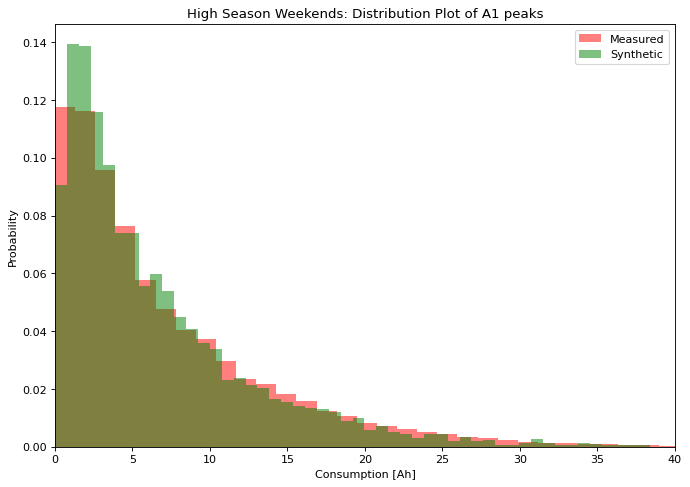

In [27]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered.ProfileID.unique()),:]
# synthetic_peaks_filtered = inv_data_df.loc[inv_data_df.index.isin(profile_ids_good_fit),:]

act_A1 = measured_peaks_filtered['A1']
# act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered['A1']
# synth_A2 = synthetic_peaks_filtered['A2']

# Normalize
kwargs = dict(alpha=0.5, bins=50, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(act_A1, **kwargs, color='r', label='Measured')
plt.hist(synth_A1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='High Season Weekends: Distribution Plot of A1 peaks', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,40)
plt.legend();

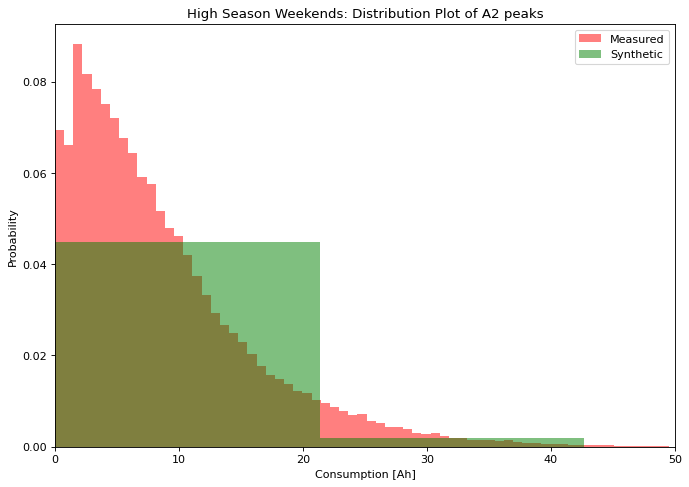

In [28]:
# act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
# synth_A1 = synthetic_peaks_filtered['A1']
synth_A2 = synthetic_peaks_filtered['A2']

# Normalize
kwargs1 = dict(alpha=0.5, bins=100, density=True, stacked=True)
kwargs2 = dict(alpha=0.5, bins=400, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(act_A2, **kwargs1, color='r', label='Measured')
plt.hist(synth_A2, **kwargs2, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='High Season Weekends: Distribution Plot of A2 peaks', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,50)
plt.legend();

In [29]:
daily_energy_synth = synthetic_df.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

# IQR
Q1 = np.percentile(daily_energy_synth['Daily Energy'], 0,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(daily_energy_synth['Daily Energy'], 90,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", daily_energy_synth.shape)
 
# Upper bound
upper = np.where(daily_energy_synth['Daily Energy'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(daily_energy_synth['Daily Energy'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
daily_energy_synth.drop(upper[0], inplace = True)
daily_energy_synth.drop(lower[0], inplace = True)
 
print("New Shape: ", daily_energy_synth.shape)

Old Shape:  (225145, 2)
New Shape:  (220950, 2)


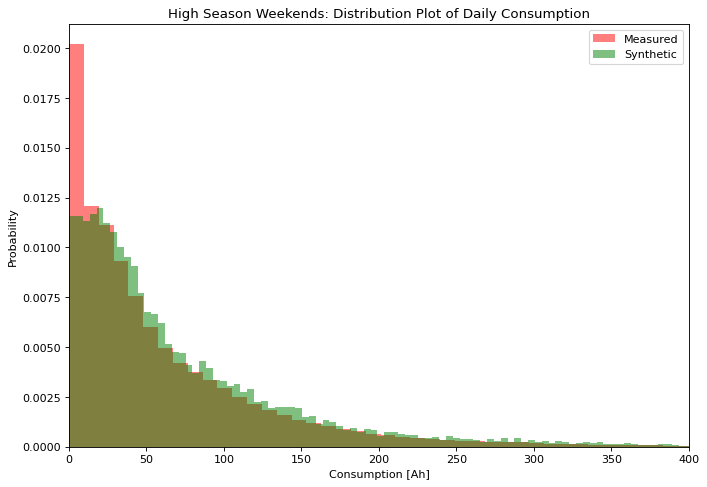

In [30]:
new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='High Season Weekends: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,400)
plt.legend();

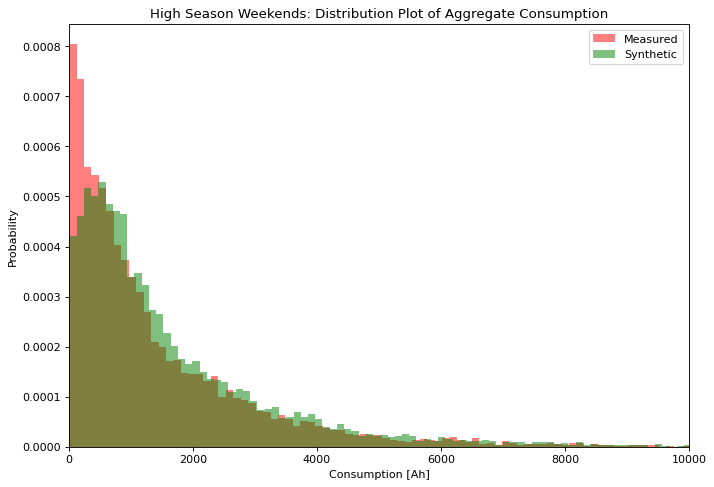

In [31]:
x1 = daily_energy_synth_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000
x2 = daily_energy_actual_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='High Season Weekends: Distribution Plot of Aggregate Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,10000)
plt.legend();